In [4]:
# Read all CSV files containing 'divvy' in their filename from the dataset folder
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime

In [12]:
# dataset folder (Windows path)
dataset_dir = Path(r"D:\myfiles\project\bike_prediction\dataset")
# find files with 'divvy' in the filename
csv_files = sorted(dataset_dir.glob("*divvy*.csv"))
print(f"Found {len(csv_files)} file(s):")
for p in csv_files:
    print(' -', p.name)

# read them into dataframes and tag source filename
dfs = []
for f in csv_files:
    try:
        df = pd.read_csv(f)
        df['__source_file'] = f.name
        dfs.append(df)
    except Exception as e:
        print(f"Failed to read {f.name}: {e}")

# combine (if any)
if dfs:
    combined = pd.concat(dfs, ignore_index=True)
else:
    combined = pd.DataFrame()

print('Combined shape:', combined.shape)
combined.head()


Found 5 file(s):
 - 202504-divvy-tripdata.csv
 - 202505-divvy-tripdata.csv
 - 202506-divvy-tripdata.csv
 - 202507-divvy-tripdata.csv
 - 202508-divvy-tripdata.csv
Combined shape: (3106310, 14)
Combined shape: (3106310, 14)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,__source_file
0,AF3863596DF9D94B,classic_bike,2025-04-27 14:29:34.619,2025-04-27 14:36:23.584,Troy St & Elston Ave,15631,Richmond St & Diversey Ave,15645,41.945244,-87.706650,41.931902,-87.701195,member,202504-divvy-tripdata.csv
1,8B38081EBE918800,electric_bike,2025-04-23 17:48:51.863,2025-04-23 17:59:06.015,Wabash Ave & Adams St,KA1503000015,Green St & Madison St,TA1307000120,41.879472,-87.625689,41.881859,-87.649264,member,202504-divvy-tripdata.csv
2,1C7F1DE826BBBC8D,electric_bike,2025-04-05 17:55:30.845,2025-04-05 18:05:40.032,Damen Ave & Cortland St,13133,California Ave & Fletcher St,15642,41.915983,-87.677335,41.938429,-87.698008,member,202504-divvy-tripdata.csv
3,CAD23D69A79A6C3B,classic_bike,2025-04-03 08:22:04.493,2025-04-03 08:32:06.099,Clark St & Elm St,TA1307000039,Orleans St & Merchandise Mart Plaza,TA1305000022,41.902973,-87.631280,41.888243,-87.636390,member,202504-divvy-tripdata.csv
4,BE241E601482E0AB,electric_bike,2025-04-15 06:09:55.293,2025-04-15 06:19:58.942,Western Ave & Walton St,KA1504000103,Damen Ave & Charleston St,13288,41.898418,-87.686596,41.920082,-87.677855,member,202504-divvy-tripdata.csv


In [13]:
# Aggregate hourly inflow/outflow per station

# Ensure the combined orders table exists
if 'combined' not in globals():
    print("Variable 'combined' not found. Run the previous cell that reads CSVs to create it.")
else:
    df = combined.copy()

    # Ensure datetime columns are parsed
    for col in ['started_at', 'ended_at']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # 统一station_id类型为字符串，避免mixtype问题
    for col in ['start_station_id', 'end_station_id']:
        if col in df.columns:
            df[col] = df[col].astype(str)


    # OUTFLOW: use started_at and start_station_id
    out = df.dropna(subset=['started_at', 'start_station_id']).copy()
    out['hour'] = out['started_at'].dt.floor('h')
    outflow = (
        out.groupby(['start_station_id', 'hour'])
        .size()
        .reset_index(name='outflow')
        .rename(columns={'start_station_id': 'station_id'})
    )

    # INFLOW: use ended_at and end_station_id
    inn = df.dropna(subset=['ended_at', 'end_station_id']).copy()
    inn['hour'] = inn['ended_at'].dt.floor('h')
    inflow = (
        inn.groupby(['end_station_id', 'hour'])
        .size()
        .reset_index(name='inflow')
        .rename(columns={'end_station_id': 'station_id'})
    )

    # Merge inflow and outflow
    hourly = pd.merge(inflow, outflow, on=['station_id', 'hour'], how='outer').fillna(0)

    # Try to convert station_id to numeric if possible
    try:
        hourly['station_id'] = pd.to_numeric(hourly['station_id'])
    except Exception:
        pass

    hourly = hourly.sort_values(['station_id', 'hour']).reset_index(drop=True)

    # Create a complete date range from 2025-04-01 00:00 to 2025-08-31 23:00
    start_time = pd.Timestamp('2025-04-01 00:00:00')
    end_time = pd.Timestamp('2025-08-31 23:00:00')
    full_hours = pd.date_range(start=start_time, end=end_time, freq='h')
    
    # Get all unique station IDs
    all_stations = hourly['station_id'].unique()
    
    # Create a complete cartesian product of (station_id, hour)
    complete_index = pd.MultiIndex.from_product(
        [all_stations, full_hours],
        names=['station_id', 'hour']
    )
    complete_df = pd.DataFrame(index=complete_index).reset_index()
    
    # Merge with hourly data and fill missing values with 0
    hourly = pd.merge(complete_df, hourly, on=['station_id', 'hour'], how='left').fillna(0)
    hourly = hourly.sort_values(['station_id', 'hour']).reset_index(drop=True)

    print('Hourly flow (station_id, hour, inflow, outflow) shape:', hourly.shape)
    display(hourly.head(20))



Hourly flow (station_id, hour, inflow, outflow) shape: (11486016, 4)


,station_id,hour,inflow,outflow
0,24321,2025-04-01 00:00:00,0.0,0.0
1,24321,2025-04-01 01:00:00,0.0,0.0
2,24321,2025-04-01 02:00:00,0.0,0.0
3,24321,2025-04-01 03:00:00,0.0,0.0
4,24321,2025-04-01 04:00:00,0.0,0.0
5,24321,2025-04-01 05:00:00,0.0,0.0
6,24321,2025-04-01 06:00:00,0.0,0.0
7,24321,2025-04-01 07:00:00,0.0,0.0
8,24321,2025-04-01 08:00:00,0.0,0.0
9,24321,2025-04-01 09:00:00,0.0,0.0


In [13]:
out1 = out.groupby(['start_station_id']).size().sort_values(ascending=False).reset_index(name='total_outflow')
# out1.head(50)
print(out1.count())
print(out1[out1['total_outflow']>1000].count())

start_station_id    3072
total_outflow       3072
dtype: int64
start_station_id    653
total_outflow       653
dtype: int64


In [14]:
# hourly.columns: ['station_id', 'hour', 'inflow', 'outflow']

# 确保排序正确
hourly = hourly.sort_values(['station_id', 'hour']).reset_index(drop=True)

# 为每个站点计算未来12小时的累计 inflow/outflow
hourly['future_12h_inflow'] = (
    hourly.groupby('station_id')['inflow']
    .transform(lambda x: x[::-1].rolling(window=12, min_periods=12).sum()[::-1])
)

hourly['future_12h_outflow'] = (
    hourly.groupby('station_id')['outflow']
    .transform(lambda x: x[::-1].rolling(window=12, min_periods=12).sum()[::-1])
)

# 计算未来12小时净流出
hourly['future_12h_netflow'] = hourly['future_12h_inflow'] - hourly['future_12h_outflow']

# 提取日期和小时（方便查看）
hourly['date'] = hourly['hour'].dt.date
hourly['hour_of_day'] = hourly['hour'].dt.hour

# 仅保留到 8月30日0时（因为再往后不足12小时）
cutoff = pd.Timestamp('2025-08-30 23:00:00')
hourly_future12 = hourly[hourly['hour'] <= cutoff].copy()

# 选择输出列
hourly_future12 = hourly_future12[[
    'station_id', 'date', 'hour', 'hour_of_day', 
    'future_12h_inflow', 'future_12h_outflow', 'future_12h_netflow'
]]

print("Result shape:", hourly_future12.shape)
display(hourly_future12.head(20))


hourly_future12.to_csv('site_feature12_df_divvy.csv', index=False)


Result shape: (11410944, 7)


,station_id,date,hour,hour_of_day,future_12h_inflow,future_12h_outflow,future_12h_netflow
0,24321,2025-04-01,2025-04-01 00:00:00,0,0.0,0.0,0.0
1,24321,2025-04-01,2025-04-01 01:00:00,1,0.0,0.0,0.0
2,24321,2025-04-01,2025-04-01 02:00:00,2,0.0,0.0,0.0
3,24321,2025-04-01,2025-04-01 03:00:00,3,0.0,0.0,0.0
4,24321,2025-04-01,2025-04-01 04:00:00,4,0.0,0.0,0.0
5,24321,2025-04-01,2025-04-01 05:00:00,5,0.0,0.0,0.0
6,24321,2025-04-01,2025-04-01 06:00:00,6,0.0,0.0,0.0
7,24321,2025-04-01,2025-04-01 07:00:00,7,0.0,0.0,0.0
8,24321,2025-04-01,2025-04-01 08:00:00,8,0.0,0.0,0.0
9,24321,2025-04-01,2025-04-01 09:00:00,9,0.0,0.0,0.0


In [8]:
hourly_future12.to_csv('site_feature12_df_divvy.csv', index=False)
import gc
gc.collect()

0

In [15]:
# 第一步:读取feature12_df.csv
print("Step 1: Reading feature12_df.csv...")
# hourly_future12 = pd.read_csv('feature12_df.csv')
# hourly_future12['hour'] = pd.to_datetime(hourly_future12['hour'], errors='coerce')
print(f"Loaded shape: {hourly_future12.shape}")
print(f"Columns: {hourly_future12.columns.tolist()}")

# 第二步：从原始订单表中筛选4月1日-7月1日平均每日流出订单量>=10的点位
if 'combined' not in globals():
    print("ERROR: 'combined' not found. Run the previous cells first.")
else:
    print("\nStep 2: Filtering stations by average daily orders (Apr 1 - Jul 1)...")
    df_orders = combined.copy()
    
    # 统一station_id类型为字符串，避免mixtype问题
    for col in ['start_station_id', 'end_station_id']:
        if col in df_orders.columns:
            df_orders[col] = df_orders[col].astype(str)
    
    # 解析时间列
    for col in ['started_at', 'ended_at']:
        if col in df_orders.columns:
            df_orders[col] = pd.to_datetime(df_orders[col], errors='coerce')
    
    # 筛选时间范围：2025-04-01 到 2025-07-01
    start_date = pd.Timestamp('2025-04-01')
    end_date = pd.Timestamp('2025-07-01')
    
    # 按started_at筛选出发站点
    df_out = df_orders[(df_orders['started_at'] >= start_date) & (df_orders['started_at'] < end_date)].copy()
    df_out['date'] = df_out['started_at'].dt.date
    
    # 计算每个站点每日的出发订单量
    daily_out = df_out.groupby(['start_station_id', 'date']).size().reset_index(name='count')
 
    # 对于每个站点，计算平均每日订单量
    avg_daily_out = daily_out.groupby('start_station_id')['count'].mean().reset_index(name='avg_daily_orders')
    
    # 筛选平均每日订单量 >= 10 的站点
    high_traffic_stations = avg_daily_out[avg_daily_out['avg_daily_orders'] >= 10]['start_station_id'].unique()
    print(f"Found {len(high_traffic_stations)} stations with avg daily orders >= 10")
    print(f"Sample stations: {high_traffic_stations[:5].tolist()}")
    
    # 统一hourly_future12的station_id为字符串类型
    hourly_future12['station_id'] = hourly_future12['station_id'].astype(str)
    
    # 第三步：在future12_df中筛选这些站点作为训练样本
    print("\nStep 3: Filtering training samples from future12_df...")
    lag_feature_df = hourly_future12[hourly_future12['station_id'].isin(high_traffic_stations)].copy()
    print(f"Training samples shape: {lag_feature_df.shape}")
    
    # 第四步：生成lag特征
    print("\nStep 4: Creating lag features (12h_max_net_flow from 1d/2d/6d/13d ago)...")
    
    # 确保按站点和小时排序
    lag_feature_df = lag_feature_df.sort_values(['station_id', 'hour']).reset_index(drop=True)
    
    # 定义lag周期（以小时为单位）
    lag_days = [1, 2, 6, 13]
    lag_hours = {1: 24, 2: 48, 6: 144, 13: 312}  # 1天=24小时，2天=48小时等
    
    for days, hours_lag in lag_hours.items():
        col_name = f'net_flow_12h_lag_{days}d'
        lag_feature_df[col_name] = lag_feature_df.groupby('station_id')['future_12h_netflow'].shift(hours_lag)
    
    # 显示结果
    print("\nFinal training dataframe shape:", lag_feature_df.shape)
    print("Columns:", lag_feature_df.columns.tolist())
    print("\nFirst 20 rows:")
    display(lag_feature_df.head(20))
    
    # 检查station_id是否有重复问题
    station_counts = lag_feature_df.groupby('station_id').size()
    print(f"\nStation ID统计: 共{len(station_counts)}个不同的站点")
    print(f"每站行数统计: min={station_counts.min()}, max={station_counts.max()}, unique_counts={station_counts.nunique()}")
    
    # 显示缺失值统计
    print("\nMissing values:")
    print(lag_feature_df.isnull().sum())
    
    # 保存为变量供后续使用
    lag_feature_df.to_csv('lag_feature_df_divvy.csv', index=False)
    print("\nTrain sample dataframe saved as 'lag_feature_df'")


Step 1: Reading feature12_df.csv...
Loaded shape: (11410944, 7)
Columns: ['station_id', 'date', 'hour', 'hour_of_day', 'future_12h_inflow', 'future_12h_outflow', 'future_12h_netflow']

Step 2: Filtering stations by average daily orders (Apr 1 - Jul 1)...
Found 753 stations with avg daily orders >= 10
Sample stations: ['13001', '13006', '13008', '13011', '13016']

Step 3: Filtering training samples from future12_df...
Found 753 stations with avg daily orders >= 10
Sample stations: ['13001', '13006', '13008', '13011', '13016']

Step 3: Filtering training samples from future12_df...
Training samples shape: (2746944, 7)

Step 4: Creating lag features (12h_max_net_flow from 1d/2d/6d/13d ago)...
Training samples shape: (2746944, 7)

Step 4: Creating lag features (12h_max_net_flow from 1d/2d/6d/13d ago)...

Final training dataframe shape: (2746944, 11)
Columns: ['station_id', 'date', 'hour', 'hour_of_day', 'future_12h_inflow', 'future_12h_outflow', 'future_12h_netflow', 'net_flow_12h_lag_1d',

,station_id,date,hour,hour_of_day,future_12h_inflow,future_12h_outflow,future_12h_netflow,net_flow_12h_lag_1d,net_flow_12h_lag_2d,net_flow_12h_lag_6d,net_flow_12h_lag_13d
0,13001,2025-04-01,2025-04-01 00:00:00,0,23.0,13.0,10.0,NaN,NaN,NaN,NaN
1,13001,2025-04-01,2025-04-01 01:00:00,1,23.0,16.0,7.0,NaN,NaN,NaN,NaN
2,13001,2025-04-01,2025-04-01 02:00:00,2,25.0,18.0,7.0,NaN,NaN,NaN,NaN
3,13001,2025-04-01,2025-04-01 03:00:00,3,28.0,19.0,9.0,NaN,NaN,NaN,NaN
4,13001,2025-04-01,2025-04-01 04:00:00,4,31.0,22.0,9.0,NaN,NaN,NaN,NaN
5,13001,2025-04-01,2025-04-01 05:00:00,5,33.0,30.0,3.0,NaN,NaN,NaN,NaN
6,13001,2025-04-01,2025-04-01 06:00:00,6,36.0,36.0,0.0,NaN,NaN,NaN,NaN
7,13001,2025-04-01,2025-04-01 07:00:00,7,40.0,36.0,4.0,NaN,NaN,NaN,NaN
8,13001,2025-04-01,2025-04-01 08:00:00,8,34.0,33.0,1.0,NaN,NaN,NaN,NaN
9,13001,2025-04-01,2025-04-01 09:00:00,9,26.0,33.0,-7.0,NaN,NaN,NaN,NaN



Station ID统计: 共753个不同的站点
每站行数统计: min=3648, max=3648, unique_counts=1

Missing values:
station_id                   0
date                         0
hour                         0
hour_of_day                  0
future_12h_inflow            0
future_12h_outflow           0
future_12h_netflow           0
net_flow_12h_lag_1d      18072
net_flow_12h_lag_2d      36144
net_flow_12h_lag_6d     108432
net_flow_12h_lag_13d    234936
dtype: int64
station_id                   0
date                         0
hour                         0
hour_of_day                  0
future_12h_inflow            0
future_12h_outflow           0
future_12h_netflow           0
net_flow_12h_lag_1d      18072
net_flow_12h_lag_2d      36144
net_flow_12h_lag_6d     108432
net_flow_12h_lag_13d    234936
dtype: int64

Train sample dataframe saved as 'lag_feature_df'

Train sample dataframe saved as 'lag_feature_df'


In [2]:
import pandas as pd
lag_feature_df = pd.read_csv('lag_feature_df_divvy.csv')
lag_feature_df.shape

C:\Users\Zusong Zhang\AppData\Local\Temp\ipykernel_28928\3698132358.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  lag_feature_df = pd.read_csv('lag_feature_df_divvy.csv')


(2743296, 11)

In [1]:
lag_feature_df['station_id'].value_counts()

NameError: name 'lag_feature_df' is not defined

In [4]:
lag_feature_df[0:30]

,station_id,date,hour,hour_of_day,future_12h_inflow,future_12h_outflow,future_12h_netflow,net_flow_12h_lag_1d,net_flow_12h_lag_2d,net_flow_12h_lag_6d,net_flow_12h_lag_13d
0,13001,2025-04-01,2025-04-01 00:00:00,0,23.0,13.0,10.0,NaN,NaN,NaN,NaN
1,13001,2025-04-01,2025-04-01 01:00:00,1,23.0,16.0,7.0,NaN,NaN,NaN,NaN
2,13001,2025-04-01,2025-04-01 02:00:00,2,25.0,18.0,7.0,NaN,NaN,NaN,NaN
3,13001,2025-04-01,2025-04-01 03:00:00,3,28.0,19.0,9.0,NaN,NaN,NaN,NaN
4,13001,2025-04-01,2025-04-01 04:00:00,4,31.0,22.0,9.0,NaN,NaN,NaN,NaN
5,13001,2025-04-01,2025-04-01 05:00:00,5,33.0,30.0,3.0,NaN,NaN,NaN,NaN
6,13001,2025-04-01,2025-04-01 06:00:00,6,36.0,36.0,0.0,NaN,NaN,NaN,NaN
7,13001,2025-04-01,2025-04-01 07:00:00,7,40.0,36.0,4.0,NaN,NaN,NaN,NaN
8,13001,2025-04-01,2025-04-01 08:00:00,8,34.0,33.0,1.0,NaN,NaN,NaN,NaN
9,13001,2025-04-01,2025-04-01 09:00:00,9,26.0,33.0,-7.0,NaN,NaN,NaN,NaN


In [16]:
# 将 lag_feature_df 转换为按站点聚合的 JSON 数组并保存
# 1) 准备数据：优先使用内存中的 lag_feature_df，否则从磁盘读取
if 'lag_feature_df' in globals():
    df = lag_feature_df.copy()
    print("Using in-memory 'lag_feature_df'.")
else:
    try:
        df = pd.read_csv('lag_feature_df_divvy.csv')
        print("Loaded 'lag_feature_df_divvy.csv'.")
    except FileNotFoundError:
        raise FileNotFoundError("未找到 lag_feature_df_divvy.csv，且变量 lag_feature_df 不存在。请先运行上游特征生成单元。")

# 2) 规范时间列（若存在），确保排序稳定后再移除
if 'hour' in df.columns:
    df['hour'] = pd.to_datetime(df['hour'], errors='coerce')
    # 保留不存在none的时间部分
    start_date = pd.Timestamp('2025-04-15 00:00:00')
    df = df[(df['hour'] >= start_date)]


sort_cols = ['station_id'] + (['hour'] if 'hour' in df.columns else [])
df = df.sort_values(sort_cols).reset_index(drop=True)

# 3) 去除不再保留的时间列
cols_to_drop = ['date', 'hour']
cols_to_keep = ['future_12h_netflow', 'future_12h_inflow', 'future_12h_outflow', 
                'net_flow_12h_lag_1d', 'net_flow_12h_lag_2d', 'net_flow_12h_lag_6d',
                'net_flow_12h_lag_13d', 'hour_of_day']

df_nottime = df.drop(columns=cols_to_drop)
df_nottime = df_nottime[ ['station_id'] + cols_to_keep]

# 4) 选择特征列（除 station_id 外全部作为特征）
feature_cols = [c for c in df_nottime.columns if c != 'station_id']
print(f"Feature columns ({len(feature_cols)}):", feature_cols)

# 5) 将每个站点的特征按行组装为二维数组（list of lists）
records = []
for sid, g in df_nottime.groupby('station_id', sort=False):
    features_array = g[feature_cols].values.tolist()
    records.append({
        'station_id': sid,
        'features': features_array
    })

print(f"Total stations serialized: {len(records)}")

# 6) 保存为 JSON Lines（每行一个站点的特征数组）和 CSV（第二列为 JSON 字符串）

# def _to_serializable(obj):
#     if isinstance(obj, (np.integer,)):
#         return int(obj)
#     if isinstance(obj, (np.floating,)):
#         return float(obj)
#     if isinstance(obj, (np.ndarray,)):
#         return obj.tolist()
#     if isinstance(obj, (pd.Timestamp, datetime)):
#         return obj.isoformat()
#     return obj

# jsonl_path = 'lag_feature_array_divvy.jsonl'
# with open(jsonl_path, 'w', encoding='utf-8') as f:
#     for rec in records:
#         f.write(json.dumps(rec, ensure_ascii=False, default=_to_serializable) + "\n")
# print(f"Saved JSONL: {jsonl_path}")

# 也保存为 CSV，便于快速浏览（features 为 JSON 字符串）
csv_path = 'lag_feature_array_divvy.csv'
array_df = pd.DataFrame({
    'station_id': [r['station_id'] for r in records],
    'features': [json.dumps(r['features'], ensure_ascii=False) for r in records]
})
array_df.to_csv(csv_path, index=False, sep='|')
print(f"Saved CSV: {csv_path}")

# 7) 预览前 1 个站点的前 2 条特征行
if records:
    sample = records[0]
    print("Sample station_id:", sample['station_id'])
    print("First 2 feature rows:")
    for row in sample['features'][:2]:
        print(row)

# 暴露结果变量供后续使用
lag_feature_array_records = records


Using in-memory 'lag_feature_df'.
Feature columns (8): ['future_12h_netflow', 'future_12h_inflow', 'future_12h_outflow', 'net_flow_12h_lag_1d', 'net_flow_12h_lag_2d', 'net_flow_12h_lag_6d', 'net_flow_12h_lag_13d', 'hour_of_day']
Feature columns (8): ['future_12h_netflow', 'future_12h_inflow', 'future_12h_outflow', 'net_flow_12h_lag_1d', 'net_flow_12h_lag_2d', 'net_flow_12h_lag_6d', 'net_flow_12h_lag_13d', 'hour_of_day']
Total stations serialized: 753
Total stations serialized: 753
Saved CSV: lag_feature_array_divvy.csv
Sample station_id: 13001
First 2 feature rows:
[5.0, 19.0, 14.0, 21.0, -8.0, 8.0, 1.0, 0.0]
[5.0, 20.0, 15.0, 19.0, -7.0, 9.0, 0.0, 1.0]
Saved CSV: lag_feature_array_divvy.csv
Sample station_id: 13001
First 2 feature rows:
[5.0, 19.0, 14.0, 21.0, -8.0, 8.0, 1.0, 0.0]
[5.0, 20.0, 15.0, 19.0, -7.0, 9.0, 0.0, 1.0]


In [17]:
# 将 lag_feature_array_records 转换为三维数组用于TCN模型训练
# 维度: (点位数, 时间步数, 特征数)

if 'lag_feature_array_records' not in globals():
    print("ERROR: 'lag_feature_array_records' not found. Run the previous cell first.")
else:
    # 提取所有站点的特征数组
    tcn_array_3d = np.array([record['features'] for record in lag_feature_array_records])
    
    # 提取站点ID列表（用于后续映射）
    station_ids = [record['station_id'] for record in lag_feature_array_records]
    
    print(f"TCN 3D Array shape: {tcn_array_3d.shape}")
    print(f"  - 点位数: {tcn_array_3d.shape[0]}")
    print(f"  - 时间步数: {tcn_array_3d.shape[1]}")
    print(f"  - 特征数: {tcn_array_3d.shape[2]}")
    print(f"\nStation IDs (first 5): {station_ids[:5]}")
    
    # 保存为numpy文件
    np.save('tcn_data_3d.npy', tcn_array_3d)
    np.save('station_ids.npy', np.array(station_ids))
    print(f"\n✓ Saved: tcn_data_3d.npy, station_ids.npy")


TCN 3D Array shape: (753, 3312, 8)
  - 点位数: 753
  - 时间步数: 3312
  - 特征数: 8

Station IDs (first 5): ['13001', '13006', '13008', '13011', '13016']

✓ Saved: tcn_data_3d.npy, station_ids.npy


In [9]:
del lag_feature_df

DIVVY 订单分布分析
总订单数: 3,106,310
数据时间范围: 2025-03-31 23:17:22.078000 至 2025-08-31 23:55:36.521000
站点总数: 3,072

1. 分析订单在小时上的分布...
   - 订单最多的小时: 17:00 (319463 笔)
   - 订单最少的小时: 4:00 (8880 笔)

2. 分析订单在星期几上的分布...
   - 最繁忙星期: Saturday (509341 笔)
   - 最清闲星期: Monday (387010 笔)

3. 分析点位平均流出订单数分布...
   - 选取时段内平均每站流出订单: 791
   - 中位数: 46
   - 最高站点: 35454 笔
   - 最低站点: 1 笔
   - 订单数>1000的站点: 653 个
   - 订单数>6000的站点: 71 个

4. 分析点位净流出分布...
   - 平均净流出: -9
   - 净流出为正（吸引站）: 1202 个
   - 净流出为负（发散站）: 1314 个
   - 净流出最大站点: 1075
   - 净流出最小站点: -812
   - 净流出>200的极端站点: 30 个
   - 净流出<-200的极端站点: 97 个

5. TOP 10 流出最多的点位...
   - CHI01747: 35454 笔
   - CHI00374: 19919 笔
   - CHI00525: 19760 笔
   - CHI00252: 18995 笔
   - CHI00420: 15985 笔
   - CHI00299: 14697 笔
   - CHI01742: 13257 笔
   - CHI00281: 12547 笔
   - CHI00396: 10945 笔
   - CHI00531: 10824 笔

6. 绘制每日订单数时间序列...
   - 平均每日订单数: 20303
   - 最高日订单数: 32329
   - 最低日订单数: 6342

✓ 图表已保存为 'divvy_order_distribution_analysis.png'


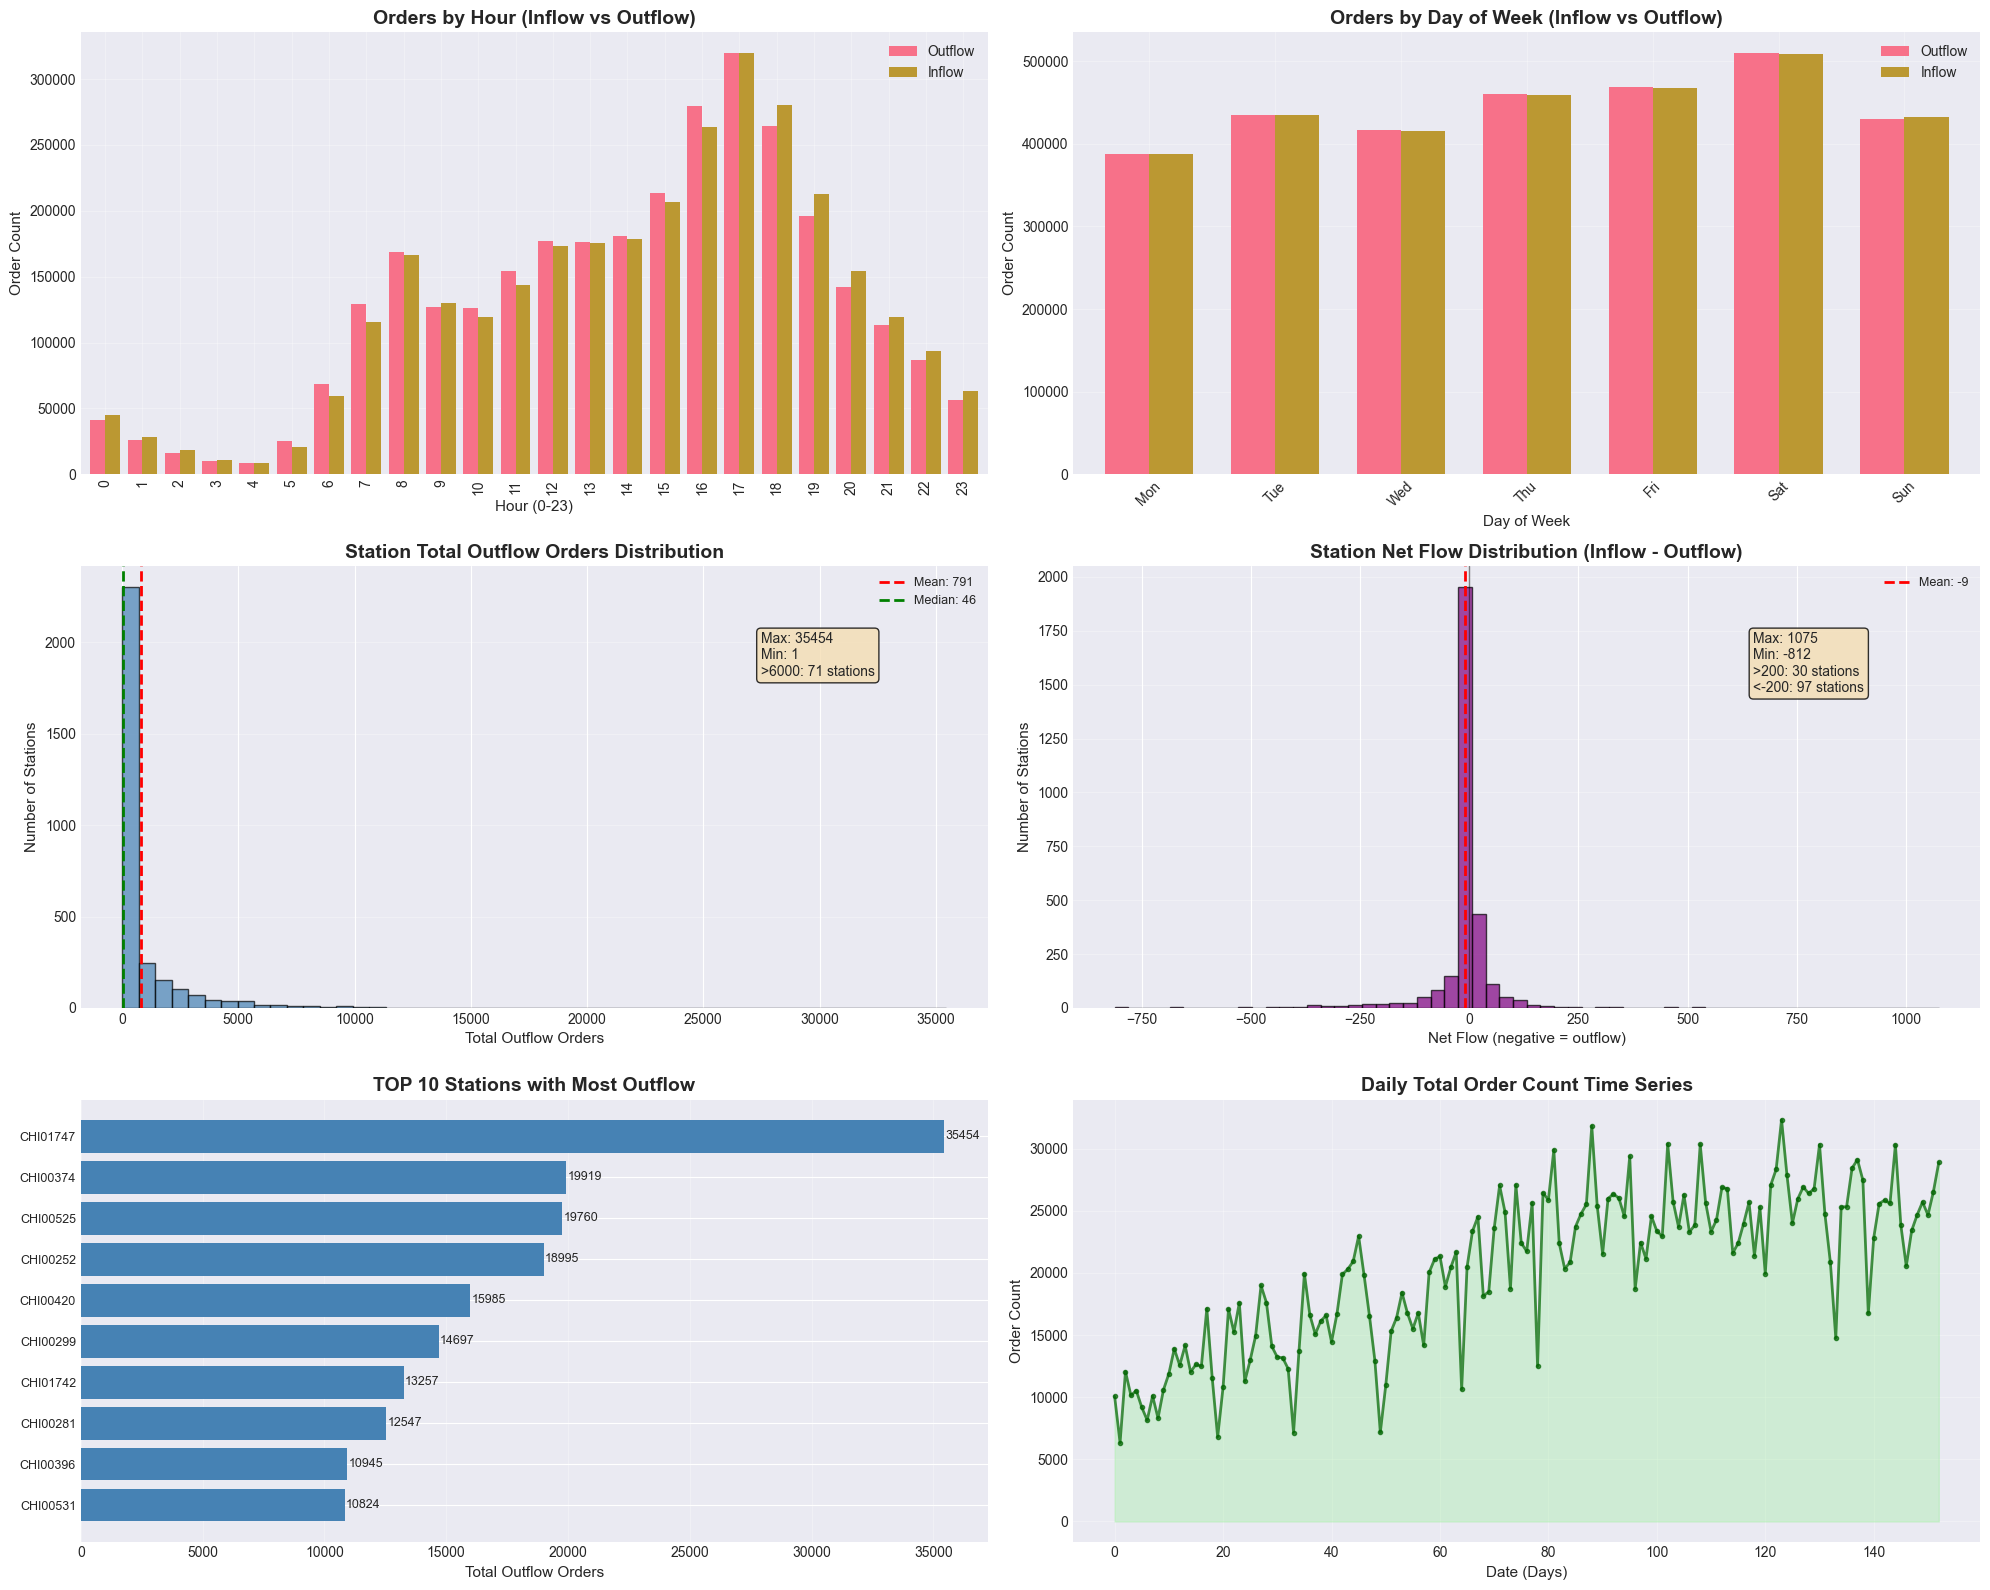


分析完成！


In [2]:
import matplotlib
# 数据分析：Divvy订单的分布特征分析与可视化
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']  # Use standard fonts to avoid Chinese encoding issues

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Check if original data exists
if 'combined' not in globals():
    print("ERROR: 'combined' not found. Please run previous cells first.")
else:
    df = combined.copy()
    
    # Ensure datetime columns are parsed
    for col in ['started_at', 'ended_at']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    print("=" * 80)
    print("DIVVY 订单分布分析")
    print("=" * 80)
    print(f"总订单数: {len(df):,}")
    print(f"数据时间范围: {df['started_at'].min()} 至 {df['started_at'].max()}")
    print(f"站点总数: {df['start_station_id'].nunique():,}")
    
    # Create figure container
    fig = plt.figure(figsize=(20, 16))
    
    # ============ 1. 订单对小时的分布 ============
    print("\n1. 分析订单在小时上的分布...")
    df['hour_of_day'] = df['started_at'].dt.hour
    
    hourly_stats = df.groupby('hour_of_day').agg({
        'started_at': 'count',  # 流出订单数
    }).rename(columns={'started_at': 'outflow'})
    
    # Count inflow orders
    df['hour_ended'] = df['ended_at'].dt.hour
    hourly_in = df.groupby('hour_ended').agg({
        'ended_at': 'count'
    }).rename(columns={'ended_at': 'inflow'})
    hourly_stats['inflow'] = hourly_in['inflow']
    hourly_stats['net_flow'] = hourly_stats['inflow'] - hourly_stats['outflow']
    
    ax1 = plt.subplot(3, 2, 1)
    hourly_stats[['outflow', 'inflow']].plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title('Orders by Hour (Inflow vs Outflow)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Hour (0-23)', fontsize=11)
    ax1.set_ylabel('Order Count', fontsize=11)
    ax1.legend(['Outflow', 'Inflow'], fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    print(f"   - 订单最多的小时: {hourly_stats['outflow'].idxmax()}:00 ({hourly_stats['outflow'].max():.0f} 笔)")
    print(f"   - 订单最少的小时: {hourly_stats['outflow'].idxmin()}:00 ({hourly_stats['outflow'].min():.0f} 笔)")
    
    # ============ 2. 订单对星期几的分布 ============
    print("\n2. 分析订单在星期几上的分布...")
    df['dayofweek'] = df['started_at'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['day_name'] = df['started_at'].dt.day_name()
    
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_stats = df.groupby('day_name').agg({
        'started_at': 'count'
    }).rename(columns={'started_at': 'outflow'}).reindex(day_order)
    
    # Count inflow orders
    df['day_ended'] = df['ended_at'].dt.day_name()
    daily_in = df.groupby('day_ended').agg({
        'ended_at': 'count'
    }).rename(columns={'ended_at': 'inflow'}).reindex(day_order)
    daily_stats['inflow'] = daily_in['inflow']
    daily_stats['net_flow'] = daily_stats['inflow'] - daily_stats['outflow']
    
    ax2 = plt.subplot(3, 2, 2)
    daily_stats[['outflow', 'inflow']].plot(kind='bar', ax=ax2, width=0.7)
    ax2.set_title('Orders by Day of Week (Inflow vs Outflow)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Day of Week', fontsize=11)
    ax2.set_ylabel('Order Count', fontsize=11)
    ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
    ax2.legend(['Outflow', 'Inflow'], fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    max_day = daily_stats['outflow'].idxmax()
    print(f"   - 最繁忙星期: {max_day} ({daily_stats.loc[max_day, 'outflow']:.0f} 笔)")
    print(f"   - 最清闲星期: {daily_stats['outflow'].idxmin()} ({daily_stats['outflow'].min():.0f} 笔)")
    
    # ============ 3. 点位平均流出订单数分布 ============
    print("\n3. 分析点位平均流出订单数分布...")
    station_outflow = df.groupby('start_station_id').size().reset_index(name='total_outflow')
    station_outflow['avg_daily_outflow'] = station_outflow['total_outflow'] / 153

    ax3 = plt.subplot(3, 2, 3)
    # 使用所有数据绘制直方图，设置合适的bins范围和数量
    all_outflow = station_outflow['total_outflow']
    n_bins = 50  # 减少bins数量使分布更平滑

    # 计算合适的bin范围，包含所有数据
    bin_range = (0, max(6000, all_outflow.max()))  # 确保包含6000以上的数据
    hist, bins, _ = ax3.hist(all_outflow, bins=n_bins, range=bin_range, 
                            edgecolor='black', alpha=0.7, color='steelblue')

    ax3.set_title('Station Total Outflow Orders Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Total Outflow Orders', fontsize=11)
    ax3.set_ylabel('Number of Stations', fontsize=11)
    ax3.axvline(all_outflow.mean(), color='r', linestyle='--', 
                linewidth=2, label=f"Mean: {all_outflow.mean():.0f}")
    ax3.axvline(all_outflow.median(), color='g', linestyle='--', 
                linewidth=2, label=f"Median: {all_outflow.median():.0f}")
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3, axis='y')

    # 添加统计信息文本框
    stats_text = f"Max: {all_outflow.max():.0f}\nMin: {all_outflow.min():.0f}\n>6000: {(all_outflow > 6000).sum()} stations"
    ax3.text(0.75, 0.85, stats_text, transform=ax3.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    print(f"   - 选取时段内平均每站流出订单: {all_outflow.mean():.0f}")
    print(f"   - 中位数: {all_outflow.median():.0f}")
    print(f"   - 最高站点: {all_outflow.max():.0f} 笔")
    print(f"   - 最低站点: {all_outflow.min():.0f} 笔")
    print(f"   - 订单数>1000的站点: {(all_outflow > 1000).sum()} 个")
    print(f"   - 订单数>6000的站点: {(all_outflow > 6000).sum()} 个")

    # ============ 4. 点位净流出分布 ============
    print("\n4. 分析点位净流出分布...")
    station_inflow = df.groupby('end_station_id').size().reset_index(name='total_inflow')
    station_inflow = station_inflow.rename(columns={'end_station_id': 'start_station_id'})

    station_netflow = station_outflow.merge(station_inflow, on='start_station_id', how='left')
    station_netflow['total_inflow'] = station_netflow['total_inflow'].fillna(0)
    station_netflow['net_flow'] = station_netflow['total_inflow'] - station_netflow['total_outflow']

    ax4 = plt.subplot(3, 2, 4)
    # 使用所有净流出数据绘制直方图
    all_netflow = station_netflow['net_flow']
    n_bins_netflow = 60  # 增加bins数量以显示更多细节

    # 设置合适的bin范围，包含极端数据
    bin_range_netflow = (min(-200, all_netflow.min()), max(200, all_netflow.max()))
    hist, bins, _ = ax4.hist(all_netflow, bins=n_bins_netflow, range=bin_range_netflow,
                            edgecolor='black', alpha=0.7, color='purple')

    ax4.set_title('Station Net Flow Distribution (Inflow - Outflow)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Net Flow (negative = outflow)', fontsize=11)
    ax4.set_ylabel('Number of Stations', fontsize=11)
    ax4.axvline(all_netflow.mean(), color='r', linestyle='--', 
                linewidth=2, label=f"Mean: {all_netflow.mean():.0f}")
    ax4.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3, axis='y')

    # 添加统计信息文本框
    extreme_pos = (all_netflow > 200).sum()
    extreme_neg = (all_netflow < -200).sum()
    stats_text = f"Max: {all_netflow.max():.0f}\nMin: {all_netflow.min():.0f}\n>200: {extreme_pos} stations\n<-200: {extreme_neg} stations"
    ax4.text(0.75, 0.85, stats_text, transform=ax4.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    print(f"   - 平均净流出: {all_netflow.mean():.0f}")
    print(f"   - 净流出为正（吸引站）: {(all_netflow > 0).sum()} 个")
    print(f"   - 净流出为负（发散站）: {(all_netflow < 0).sum()} 个")
    print(f"   - 净流出最大站点: {all_netflow.max():.0f}")
    print(f"   - 净流出最小站点: {all_netflow.min():.0f}")
    print(f"   - 净流出>200的极端站点: {extreme_pos} 个")
    print(f"   - 净流出<-200的极端站点: {extreme_neg} 个")
    
    # ============ 5. 点位流出订单排名TOP 10 ============
    print("\n5. TOP 10 流出最多的点位...")
    top_stations = station_outflow.nlargest(10, 'total_outflow')
    
    ax5 = plt.subplot(3, 2, 5)
    ax5.barh(range(len(top_stations)), top_stations['total_outflow'].values, color='steelblue')
    ax5.set_yticks(range(len(top_stations)))
    ax5.set_yticklabels(top_stations['start_station_id'].values, fontsize=9)
    ax5.set_title('TOP 10 Stations with Most Outflow', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Total Outflow Orders', fontsize=11)
    ax5.invert_yaxis()
    ax5.grid(True, alpha=0.3, axis='x')
    
    for i, v in enumerate(top_stations['total_outflow'].values):
        ax5.text(v + 50, i, f'{int(v)}', va='center', fontsize=9)
    
    for idx, row in top_stations.iterrows():
        print(f"   - {row['start_station_id']}: {row['total_outflow']:.0f} 笔")
    
    # ============ 6. 每日订单数时间序列 ============
    print("\n6. 绘制每日订单数时间序列...")
    df['date'] = df['ended_at'].dt.date
    daily_volume = df.groupby('date').size().reset_index(name='order_count')
    
    ax6 = plt.subplot(3, 2, 6)
    ax6.plot(range(len(daily_volume)), daily_volume['order_count'].values, 
             linewidth=2, marker='o', markersize=3, color='darkgreen', alpha=0.7)
    ax6.fill_between(range(len(daily_volume)), daily_volume['order_count'].values, alpha=0.3, color='lightgreen')
    ax6.set_title('Daily Total Order Count Time Series', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Date (Days)', fontsize=11)
    ax6.set_ylabel('Order Count', fontsize=11)
    ax6.grid(True, alpha=0.3)
    
    print(f"   - 平均每日订单数: {daily_volume['order_count'].mean():.0f}")
    print(f"   - 最高日订单数: {daily_volume['order_count'].max():.0f}")
    print(f"   - 最低日订单数: {daily_volume['order_count'].min():.0f}")
    
    plt.tight_layout()
    plt.savefig('divvy_order_distribution_analysis.png', dpi=300, bbox_inches='tight')
    print("\n✓ 图表已保存为 'divvy_order_distribution_analysis.png'")
    plt.show()
    
    print("\n" + "=" * 80)
    print("分析完成！")
    print("=" * 80)
